1. Loading and Cleaning Data...
2. Extracting Features (Parallel)...
   -> Total Valid Samples: 8117
   -> [INFO] Subsampling to 200 for reasonable runtime.
3. Computing Quantum Kernel Matrices (Parallel)...
   -> Done in 20.0s
4. Training SVR with Precomputed Kernel...
5. Predicting...

--- Results (N=200) ---
RMSE: 12.62
R2:   0.38


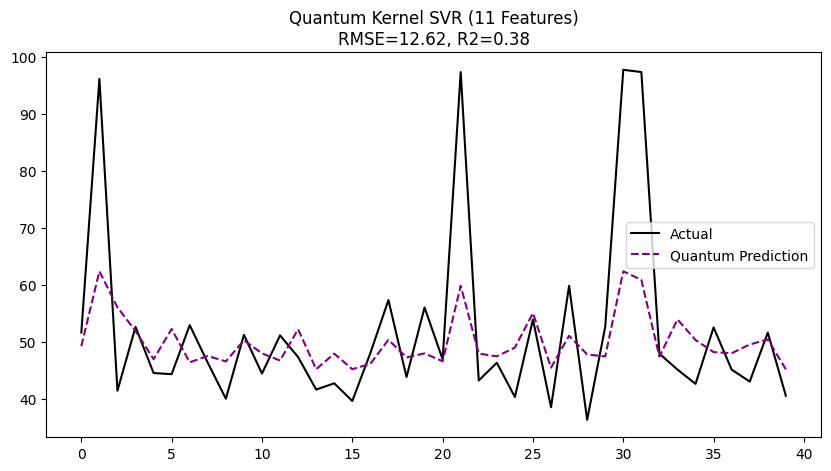

In [5]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt
import pennylane as qml
import time
from pathlib import Path

bands = {
    'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)
}

def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def permutation_entropy(time_series, order=3, delay=1):
    n = len(time_series)
    if n < order * delay: return 0
    permutations = np.array([time_series[i:i + order * delay:delay] for i in range(n - (order - 1) * delay)])
    try:
        patterns, counts = np.unique(permutations, axis=0, return_counts=True)
    except TypeError:
        perm_strings = [str(row) for row in permutations]
        patterns, counts = np.unique(perm_strings, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-10))

def spike_detection(signal, threshold=3):
    if np.std(signal) == 0: return 0
    return np.sum(np.abs(signal - np.mean(signal)) > threshold * np.std(signal))

def band_features(signal, fs):
    de_sq_list = []
    spike_list = []
    for band_name in bands:
        low, high = bands[band_name]
        try:
            filtered = bandpass_filter(signal, fs, low, high)
            var = np.var(filtered)
            if var <= 0: var = 1e-10
            de = 0.5 * np.log(2 * np.pi * np.e * var)
            de_sq_list.append(de ** 2)
            spike_list.append(spike_detection(filtered))
        except:
            de_sq_list.append(0); spike_list.append(0)

    try:
        delta_sig = bandpass_filter(signal, fs, 0.5, 4)
        pe_delta = permutation_entropy(delta_sig)
    except:
        pe_delta = 0
    return de_sq_list + spike_list + [pe_delta]

def process_window(start_idx, eeg_vals, win_size, fs):
    window = eeg_vals[start_idx : start_idx + win_size]
    if len(window) < win_size or np.all(window == 0): return None
    return band_features(window, fs)

def trim_zero_ends(eeg, bis, fs_eeg=128, fs_bis=1):
    bis_start = next((i for i, v in enumerate(bis) if v != 0), None)
    bis_end_rev = next((i for i, v in enumerate(bis[::-1]) if v != 0), None)
    if bis_start is None or bis_end_rev is None: return np.array([]), np.array([])
    bis_end = len(bis) - bis_end_rev
    bis_trimmed = bis[bis_start:bis_end]
    eeg_start = int(bis_start / fs_bis * fs_eeg)
    eeg_end = int(bis_end / fs_bis * fs_eeg)
    return eeg[eeg_start:eeg_end], bis_trimmed


n_qubits = 11
dev_kernel = qml.device("lightning.qubit", wires=n_qubits)

zeros_state = [0] * n_qubits

@qml.qnode(dev_kernel)
def kernel_circuit(x1, x2):
    qml.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Projector(zeros_state, wires=range(n_qubits)))

def compute_kernel_row(x_row, X_all):
    return [kernel_circuit(x_row, x2) for x2 in X_all]

if __name__ == "__main__":
    fs = 128
    window_sec = 56
    step_sec = 1
    advance_sec = 60

    print("1. Loading and Cleaning Data...")
    try:
        root_path = Path.cwd().parent
        data_path = root_path / "data" / "raw"
        if not data_path.exists():
            data_path = Path.cwd()

        df_bis = pd.read_csv(data_path / 'patient48_bis.csv')
        df_eeg = pd.read_csv(data_path / 'patient48_eeg.csv')
    except:
        # Fallback for simple run
        df_bis = pd.read_csv('patient48_bis.csv')
        df_eeg = pd.read_csv('patient48_eeg.csv')

    eeg_raw = df_eeg['EEG'].interpolate('linear').values
    bis_raw = df_bis['BIS'].interpolate('linear').values
    eeg, bis = trim_zero_ends(eeg_raw, bis_raw)

    print(f"2. Extracting Features (Parallel)...")
    win_samples = int(window_sec * fs)
    step_samples = int(step_sec * fs)
    starts = range(0, len(eeg) - win_samples + 1, step_samples)

    features_raw = Parallel(n_jobs=-1)(
        delayed(process_window)(s, eeg, win_samples, fs) for s in starts
    )
    X = np.array([f for f in features_raw if f is not None])

    advance_steps = int(advance_sec / step_sec)
    y = bis[advance_steps : advance_steps + len(X)]
    X = X[:len(y)]

    print(f"   -> Total Valid Samples: {len(X)}")

    # --- SUBSAMPLING ---
    limit = 200

    if limit and len(X) > limit:
        print(f"   -> [INFO] Subsampling to {limit} for reasonable runtime.")
        indices = np.linspace(0, len(X)-1, limit).astype(int)
        X = X[indices]
        y = y[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"3. Computing Quantum Kernel Matrices (Parallel)...")
    t0 = time.time()

    K_train = Parallel(n_jobs=-1)(
        delayed(compute_kernel_row)(x, X_train_scaled) for x in X_train_scaled
    )
    K_train = np.array(K_train)

    K_test = Parallel(n_jobs=-1)(
        delayed(compute_kernel_row)(x, X_train_scaled) for x in X_test_scaled
    )
    K_test = np.array(K_test)

    print(f"   -> Done in {time.time()-t0:.1f}s")

    print("4. Training SVR with Precomputed Kernel...")
    model = SVR(kernel='precomputed')
    model.fit(K_train, y_train)

    print("5. Predicting...")
    y_pred = model.predict(K_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n--- Results (N={len(X)}) ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2:   {r2:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual', color='black')
    plt.plot(y_pred, label='Quantum Prediction', color='purple', linestyle='--')
    plt.title(f"Quantum Kernel SVR (11 Features)\nRMSE={rmse:.2f}, R2={r2:.2f}")
    plt.legend()
    plt.show()